In [1]:
import glob, os
import pandas as pd
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.preprocessing import StandardScaler


In [2]:
DATA_ORGINAL_PATH = "../data/orginal/"
wavs = sorted(glob.glob(f"{DATA_ORGINAL_PATH}/*.wav"))
wavs

['../data/orginal\\ch1-2018-11-20_10-17-43_0000004.wav',
 '../data/orginal\\ch1-2018-11-20_10-20-34_0000006.wav',
 '../data/orginal\\ch1-2018-11-20_10-23-08_0000008.wav',
 '../data/orginal\\ch1-2018-11-20_10-26-36_0000010.wav',
 '../data/orginal\\ch1-2018-11-20_10-29-02_0000012.wav',
 '../data/orginal\\ch1-2018-11-20_10-31-42_0000014.wav',
 '../data/orginal\\ch1-2018-11-20_10-37-25_0000017.wav',
 '../data/orginal\\ch1-2018-11-20_10-39-58_0000019.wav',
 '../data/orginal\\ch1-2018-11-20_10-42-38_0000021.wav']

# Choose source file

In [3]:
SOURCE_FILE = os.path.basename(wavs[1])

# Code

In [4]:
def apply_begin_time(labels, offsets):
    labels['Relative Begin Time (s)'] = labels.apply (
        lambda row: row['Begin Time (s)'] - offsets[row['Begin File']],
        axis=1)

    labels['Relative End Time (s)'] = labels.apply (
        lambda row: row['End Time (s)'] - offsets[row['Begin File']],
        axis=1
    )
    
    return labels

    
def count_offsets(wavs):
    total_offset = 0.0
    offsets = {}
    for wav in wavs:
        name = os.path.basename(wav)
        duration = librosa.get_duration(filename=wav)
#         print(f"{name}: {total_offset:.4f}s")
        offsets[name] = total_offset
        total_offset += duration
    return offsets
        
    
def reformat_labels(labels, wavs):
    labels.loc[labels['USV TYPE'] == '22-kHz call', 'USV TYPE'] = '22kHz'
    labels.loc[labels['USV TYPE'] == '22-kHz', 'USV TYPE'] = '22kHz'
    
    offsets = count_offsets(wavs)
    labels = apply_begin_time(labels, offsets)
    
    return labels
    

def load_labels(input_path):
    return pd.read_csv(input_path + 'dlaUJ_VPAmodel_koh3_tickling_20190328.txt', delimiter="\t", index_col='Selection')


In [5]:
from types import SimpleNamespace

def freq_to_fft_bucket(freq, n_fft, sr):
    return (n_fft//2 + 1) * freq / (sr / 2)

def get_audio(path):
    if path not in get_audio.cache:
        get_audio.cache[path] = librosa.load(path, sr=None)
    return get_audio.cache[path]
get_audio.cache = {}

def extract_audio_frames(audio_name, data, n_fft=512, hop_length=128, trim_frames=True, verbose=False, to_remove_pivot=-0.7):
    audio_data, sr = get_audio(f"{DATA_ORGINAL_PATH}/{audio_name}")
    
    def t2f(time):
        return librosa.core.time_to_frames(time, sr=sr, hop_length=hop_length, n_fft=n_fft)

    stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)
    stft = np.abs(np.moveaxis(stft, 0, -1))
    
    frames_labels = np.array([None]*stft.shape[0])
    for idx, row in data[data['Begin File'] == audio_name].iterrows():
        # WARNING: add some offset to range boundaries ???
        
        start = t2f(row['Relative Begin Time (s)'])
        end = t2f(row['Relative End Time (s)'])
        
        low = int(freq_to_fft_bucket(row['Low Freq (Hz)'], n_fft=n_fft, sr=sr))
        high = int(freq_to_fft_bucket(row['High Freq (Hz)'], n_fft=n_fft, sr=sr)) + 1
        
        start_zero = start
        end_zero = end
            
        if trim_frames:
            max_elem_in_kolumn = np.max(stft[start:end, low:high], axis=1)
            normalized_max = (max_elem_in_kolumn - np.mean(max_elem_in_kolumn)) / np.std(max_elem_in_kolumn)

            
            while normalized_max[start - start_zero] < to_remove_pivot:
                start += 1

            while normalized_max[end - start_zero - 1] < to_remove_pivot:
                end -= 1

            if verbose:
                sns.lineplot(range(start_zero, end_zero), max_elem_in_kolumn, label="max_elem_in_kolumn")
                sns.lineplot(range(start_zero, end_zero), normalized_max, label="normalized_max")                                                                            
                
        if verbose:
            plt.figure()
            plt.imshow(stft[start_zero:end_zero, low:high].T)
            plt.axvline(start - start_zero, color='red')
            plt.axvline(end - start_zero, color='red')
            plt.show()
        
        frames_labels[start:end] = row['USV TYPE']
    
    meta = dict(
        audio_name=audio_name,
        audio_length=audio_data.size,
        n_fft=n_fft,
        hop_length=hop_length,
        sampling_rate=sr,
        trim_frames=trim_frames,
    )
    
    return SimpleNamespace(
        X=stft, y=frames_labels, meta=meta
    )

In [6]:
labels = load_labels(DATA_ORGINAL_PATH)
labels = reformat_labels(labels, wavs)

data = extract_audio_frames(SOURCE_FILE, labels)

print(data.X.shape, data.y.shape)
print(data.meta)



(234385, 257) (234385,)
{'audio_name': 'ch1-2018-11-20_10-20-34_0000006.wav', 'audio_length': 30001224, 'n_fft': 512, 'hop_length': 128, 'sampling_rate': 250000, 'trim_frames': True}


## Analize distribution of `Center Freq (Hz)` ##

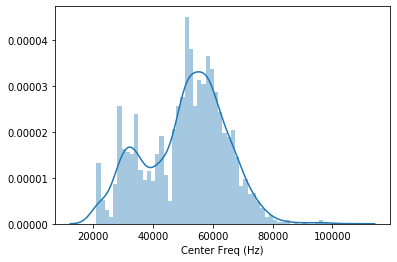

In [7]:
sns.distplot(labels['Center Freq (Hz)'], bins=60)

### Fit Gaussians to pdf ###
https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

In [8]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(2)
labels_data = np.array(labels[labels['USV TYPE'] != '22kHz']['Center Freq (Hz)']).reshape(-1, 1)
gm.fit(labels_data)

assert gm.converged_

weights = gm.weights_
means = gm.means_.reshape(-1)
variances = gm.covariances_.reshape(-1)

# print('weights:', weights)
# print('means:', means)
# print('variances:', variances)
print('predicted Mixtures:')
for i, (w, mu, sigma2) in enumerate(zip(weights, means, variances)):
    print(f"#{i+1}: w = {w:.4f}, mu = {mu:.2f}, sigma = {np.sqrt(sigma2):.2f}")

predicted Mixtures:
#1: w = 0.8302, mu = 55972.84, sigma = 9717.54
#2: w = 0.1698, mu = 32091.82, sigma = 3358.93


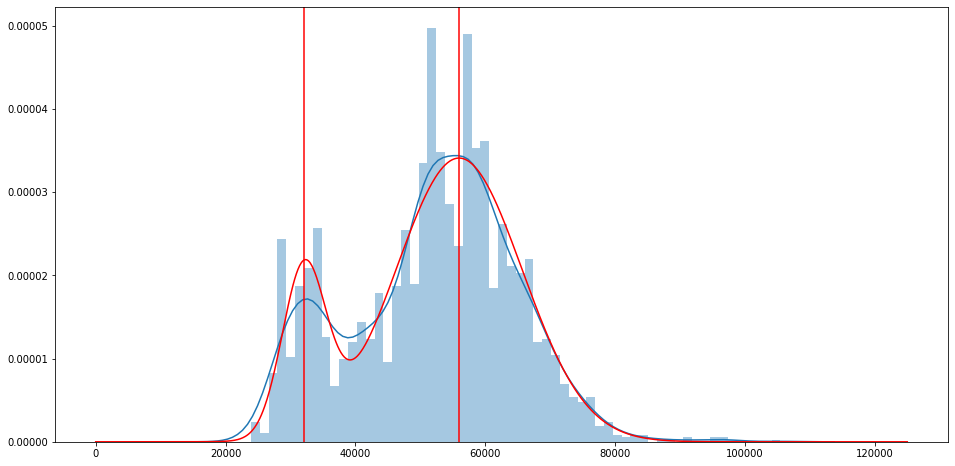

In [9]:
def normal(x, mu, sigma2):
    return (1/np.sqrt(2*np.pi*sigma2))*np.exp(-(x-mu)**2/(2*sigma2))

x = np.linspace(0, 250000/2, 1000)

y = sum(
    w*normal(x, mu, sigma2) 
    for w, mu, sigma2 in zip(weights, means, variances))

plt.figure(figsize=(16, 8))
sns.distplot(labels_data, bins=60)
sns.lineplot(x, y, color='red')
for mean in means:
    plt.axvline(x=mean, color='red')

### Analize distribution of `Center Freq (Hz)` per `USV TYPE` ###

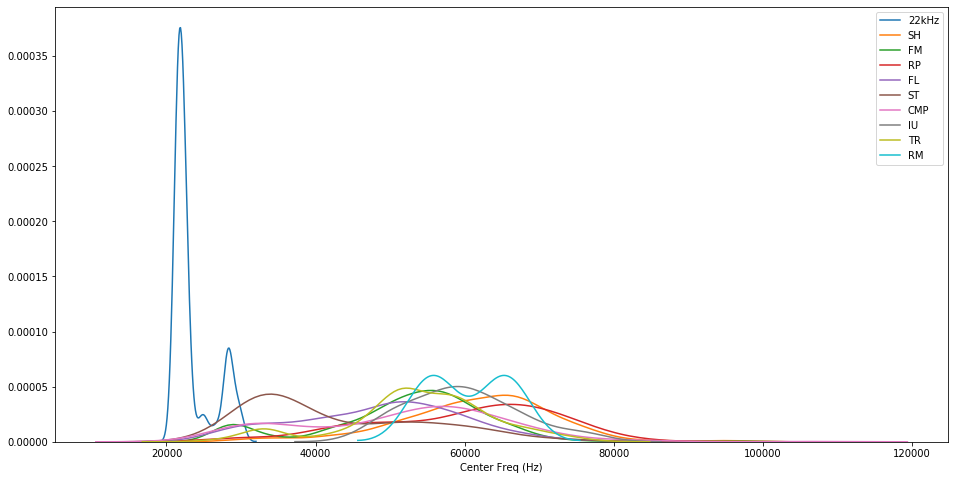

In [10]:
USV_TYPES = list(labels['USV TYPE'].unique())

plt.figure(figsize=(16, 8))
for usv_type in USV_TYPES:
    sns.distplot(labels[labels['USV TYPE'] == usv_type]['Center Freq (Hz)'], hist=False, label=usv_type)
#     print(usv_type)

## Show single annotation ##

# Display sample markers for each `USV TYPE` #

In [11]:
# https://towardsdatascience.com/audio-classification-using-fastai-and-on-the-fly-frequency-transforms-4dbe1b540f89

def show_single_marker(row, n_fft=512, hop_length=128, ax=None, verbose=False, context_size=2048):
    if verbose:
        print(row)
    path = f"{DATA_ORGINAL_PATH}/{row['Begin File']}"
    
    y, sr = get_audio(path)
    assert sr == 250000
    
    start_frame = int(row['Relative Begin Time (s)'] * sr)
    end_frame = int(row['Relative End Time (s)'] * sr)
    
    if context_size is not None:
        middle_frame = (start_frame + end_frame) // 2

        start_frame = middle_frame - context_size
        end_frame = middle_frame + context_size
    
    stft = librosa.stft(y[start_frame: end_frame], n_fft=n_fft, hop_length=hop_length)

    D = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

    librosa.display.specshow(D, x_axis=None, sr=sr, hop_length=hop_length, ax=ax)
    
    # show sample duration 
    ax.set_title(f"{row['Delta Time (s)']:.3f}s")
    
    # show marker for 'Center Freq'
    i = freq_to_fft_bucket(row['Center Freq (Hz)'], n_fft, sr)
    ax.set_yticks([i])
    ax.set_yticklabels([f"{row['Center Freq (Hz)']/1e3:.2f}kHz"], rotation='vertical')
    

### WARNING: Coś jest nie tak z ch1-2018-11-20_10-17-43_0000004.wav #

### WARNING: Czy ch1-2018-11-20_10-31-42_0000014.wav jest dobrze za annotowane? 22kHz wygląda podobnie do FM (FM zawiera RP) ##

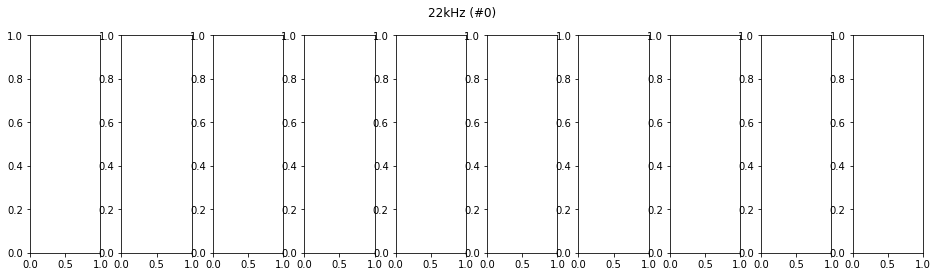

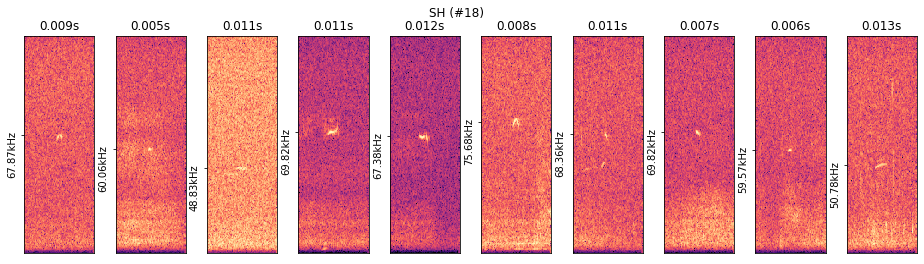

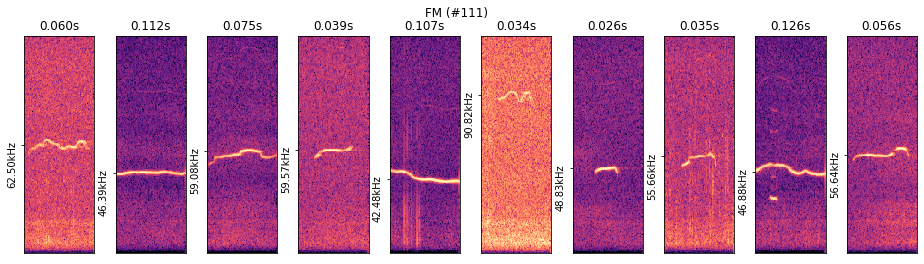

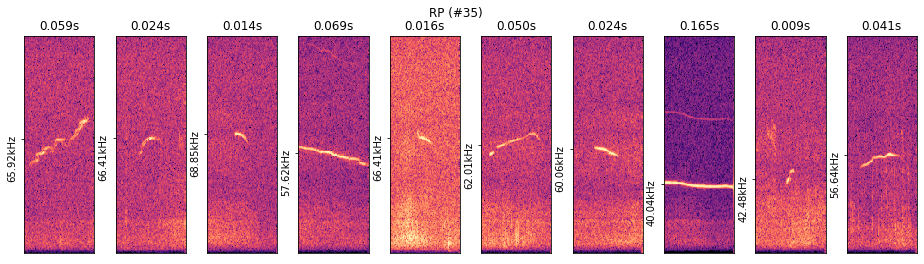

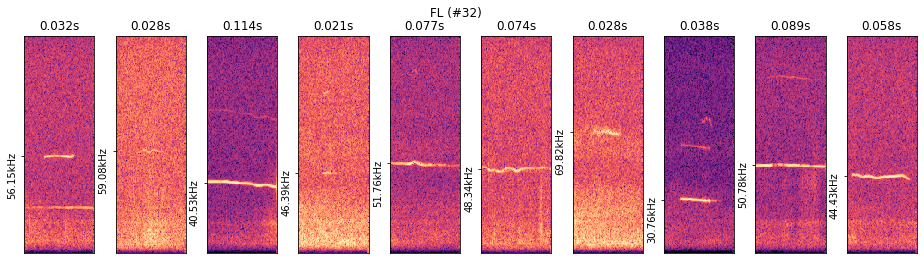

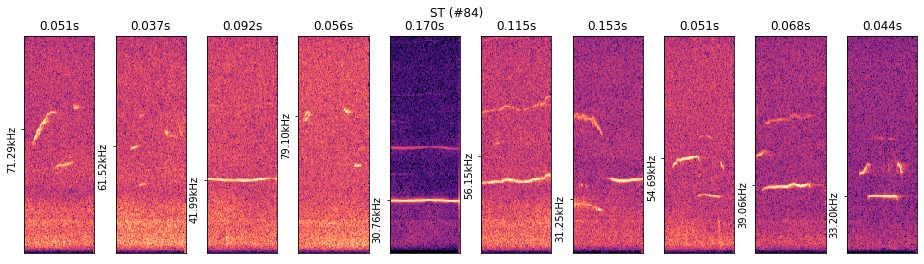

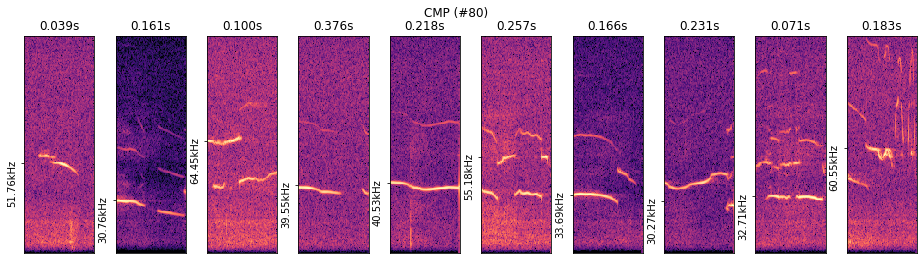

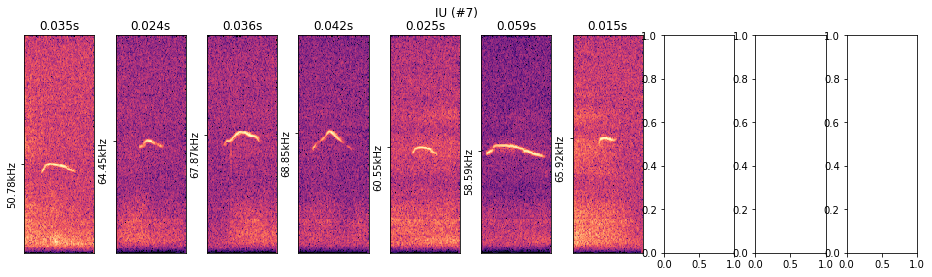

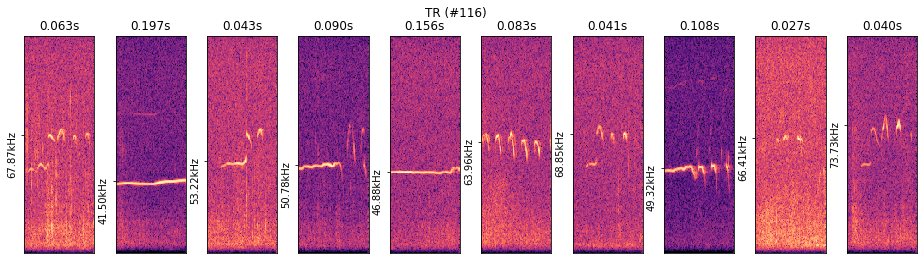

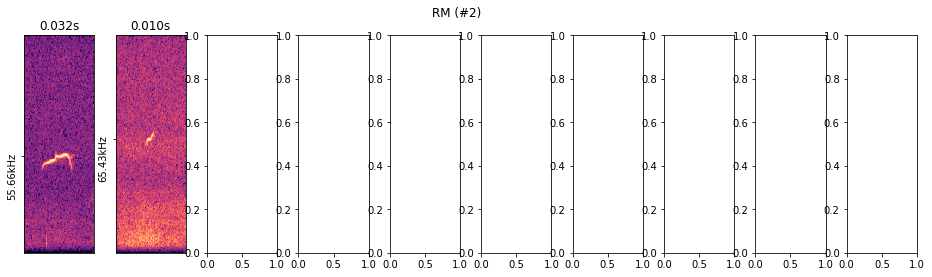

In [12]:
N = 10
for usv_type in USV_TYPES:
    rows = labels[
        (labels['Begin File'] == SOURCE_FILE) & 
        (labels['USV TYPE'] == usv_type)]
    
    fig, axs = plt.subplots(1, N, figsize=(16, 4))
    fig.suptitle(f"{usv_type} (#{len(rows)})")
    plt.subplots_adjust(wspace=0.3)

    for ax, (idx, row) in zip(axs, rows.sample(min(N, len(rows))).iterrows()):
        show_single_marker(row, ax=ax, context_size=8192)
    
# plt.colorbar(format='%+2.0f dB',)



## Display single frame ##

None 166379
22kHz 0
SH 221
FM 12846
RP 2179
FL 2583
ST 12028
CMP 21565
IU 381
TR 16144
RM 59


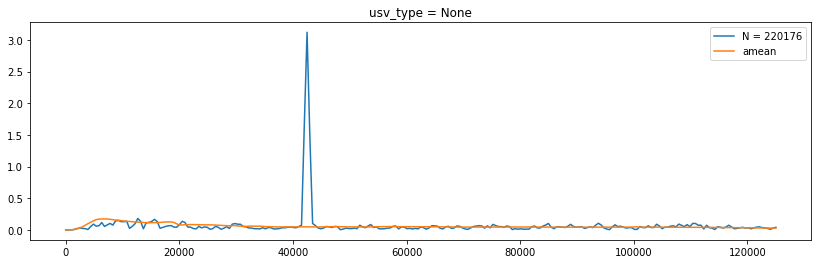

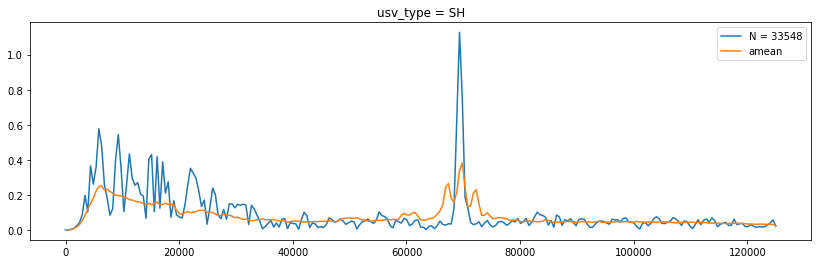

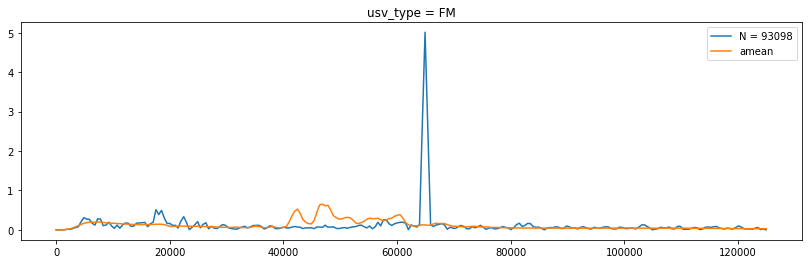

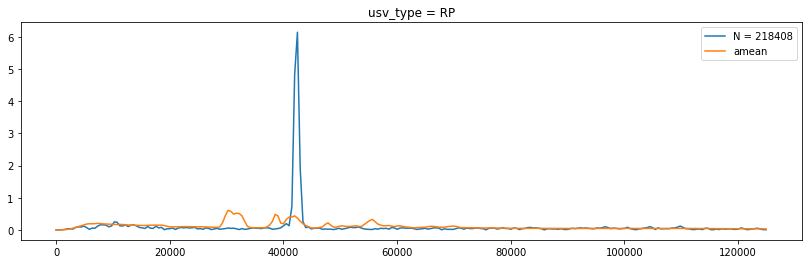

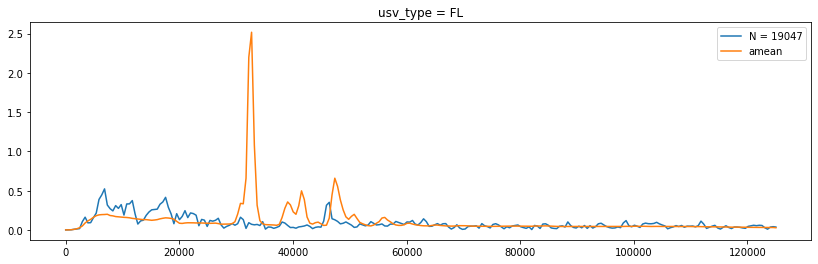

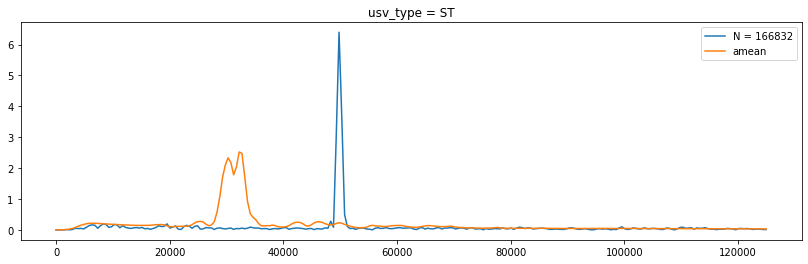

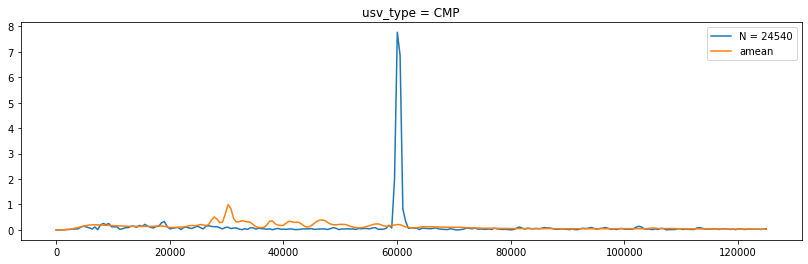

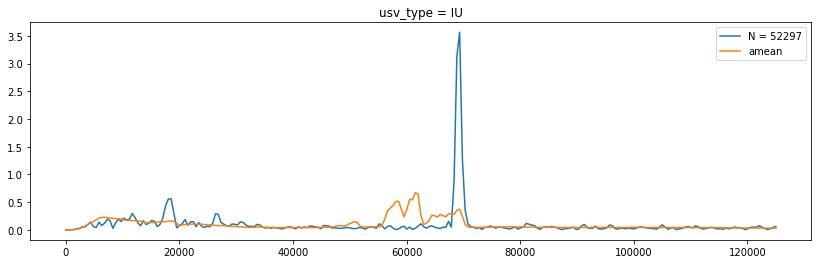

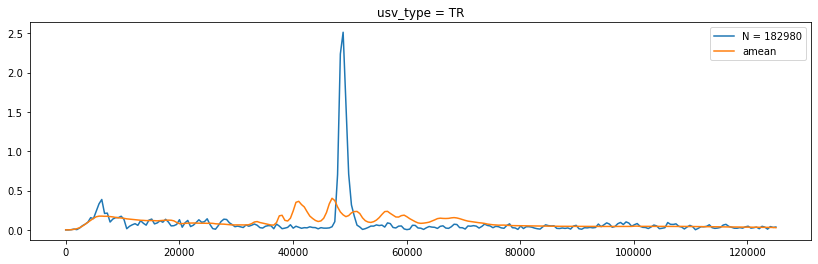

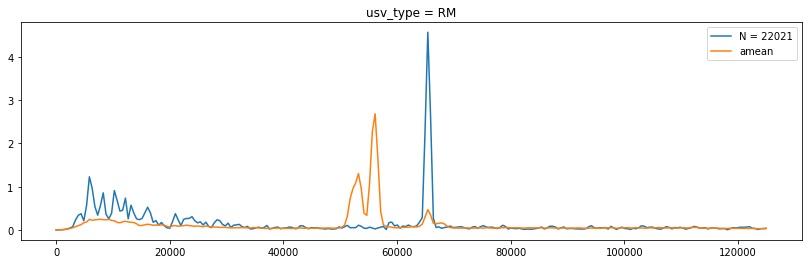

In [13]:
%matplotlib inline


def show_frame(data, usv_type):
    idx = np.argwhere(data.y == usv_type).reshape(-1)
    print(usv_type, idx.size)
    
    if not idx.size:
        return 
    
    x_hz = librosa.core.fft_frequencies(250000, data.meta['n_fft'])
    
    # display single sample of usv_type
    N = np.random.choice(idx)
    plt.figure(figsize=(14,4))
    sns.lineplot(x_hz, data.X[N], label=f"N = {N}").set_title(f"usv_type = {usv_type}")
#     print(y[N-10:N+10])
    
    # display average for given usv_type
    avg = np.mean(data.X[idx], axis=0)
    sns.lineplot(x_hz, avg, label='amean')


for usv_type in [None] + USV_TYPES:
    show_frame(data, usv_type)